In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
import zipfile

zip_file = '/content/archive.zip'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/archive')


In [3]:
import os

folder_path = '/content/archive/train/'
contents = os.listdir(folder_path)

for item in contents:
    print(item)


yawn
Closed
no_yawn
Open


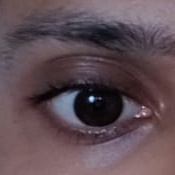

In [4]:
from PIL import Image
from IPython.display import display

image_path = '/content/archive/train/Open/_0.jpg'  # Specify the path to the image
image = Image.open(image_path)
display(image)


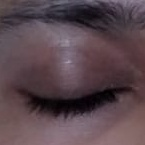

In [5]:
from PIL import Image
from IPython.display import display

image_path = '/content/archive/train/Closed/_0.jpg'
image = Image.open(image_path)
display(image)

In [6]:
from sklearn.model_selection import train_test_split

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (64, 64))
            images.append(img)
            labels.append(label)
    return images, labels

open_eye_path = '/content/archive/train/Open/'
closed_eye_path = '/content/archive/train/Closed/'

open_images, open_labels = load_images_from_folder(open_eye_path, 1)
closed_images, closed_labels = load_images_from_folder(closed_eye_path, 0)

images = np.array(open_images + closed_images)
labels = np.array(open_labels + closed_labels)



In [7]:

images = images / 255.0

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], 64, 64, 3)
X_test = X_test.reshape(X_test.shape[0], 64, 64, 3)

print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')

Training data shape: (1161, 64, 64, 3)
Testing data shape: (291, 64, 64, 3)


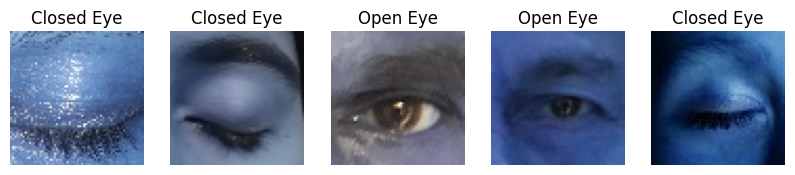

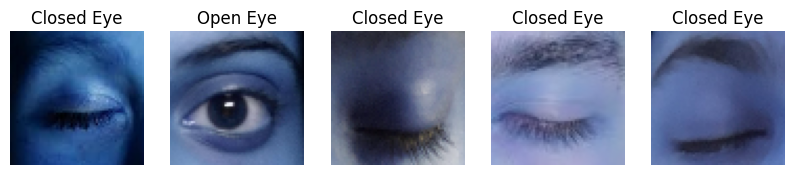

In [33]:
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i+2])
    plt.title('Open Eye' if y_train[i+2] == 1 else 'Closed Eye')
    plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i+6])
    plt.title('Open Eye' if y_train[i+6] == 1 else 'Closed Eye')
    plt.axis('off')
plt.show()

In [38]:
#Before augmentation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

old_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

old_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])


history = old_model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

oldmodel_loss, oldmodel_accuracy = old_model.evaluate(X_test, y_test)
print(f'Test loss: {oldmodel_loss}')
print(f'Test accuracy: {oldmodel_accuracy}')



Epoch 1/5
37/37 [==============================] - 8s 191ms/step - loss: 0.6835 - accuracy: 0.5409 - val_loss: 0.6735 - val_accuracy: 0.6907
Epoch 2/5
37/37 [==============================] - 5s 143ms/step - loss: 0.6624 - accuracy: 0.7476 - val_loss: 0.6470 - val_accuracy: 0.6117
Epoch 3/5
37/37 [==============================] - 7s 203ms/step - loss: 0.6148 - accuracy: 0.8079 - val_loss: 0.6222 - val_accuracy: 0.5601
Epoch 4/5
37/37 [==============================] - 6s 155ms/step - loss: 0.5298 - accuracy: 0.8183 - val_loss: 0.4665 - val_accuracy: 0.8832
Epoch 5/5
10/10 [==============================] - 0s 35ms/step - loss: 0.6995 - accuracy: 0.6014
Test loss: 0.6995222568511963
Test accuracy: 0.6013745665550232


1/1 [==============================] - 0s 27ms/step


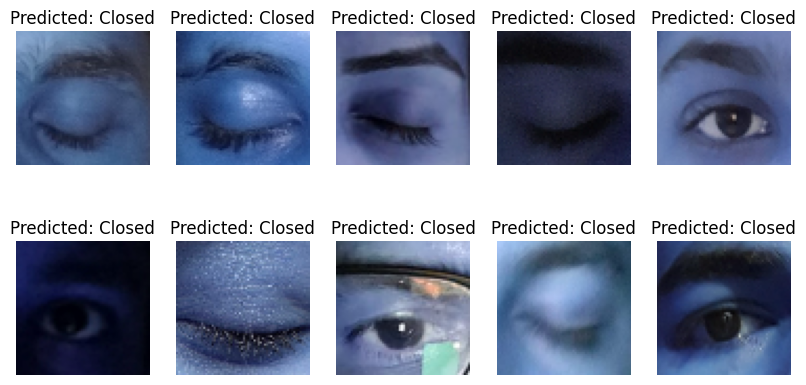

In [42]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i])
    plt.title('Predicted: ' + ('Open' if old_model.predict(X_test[i].reshape(1, 64, 64, 3)) > 0.5 else 'Closed'))
    plt.axis('off')
plt.show()

In [15]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)


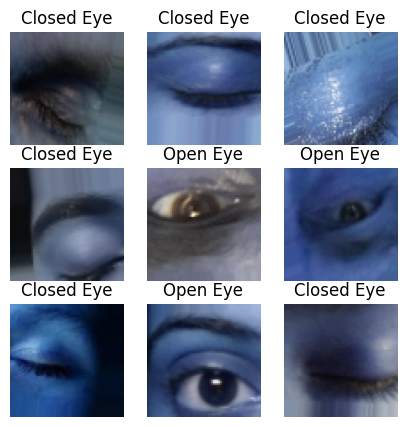

In [43]:
plt.figure(figsize=(5, 5))
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, shuffle=False):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X_batch[i])
        plt.title('Open Eye' if y_batch[i] == 1 else 'Closed Eye')
        plt.axis('off')
    break
plt.show()

In [46]:
#AFTER DATA AUGMENTATION

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history1 = model.fit( datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test))

newmodel_loss, newmodel_accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {newmodel_loss}')
print(f'Test accuracy: {newmodel_accuracy}')



Epoch 1/10
37/37 [==============================] - 11s 257ms/step - loss: 0.6068 - accuracy: 0.6770 - val_loss: 0.3451 - val_accuracy: 0.8832
Epoch 2/10
37/37 [==============================] - 10s 276ms/step - loss: 0.4420 - accuracy: 0.8208 - val_loss: 0.2899 - val_accuracy: 0.8969
Epoch 3/10
37/37 [==============================] - 13s 345ms/step - loss: 0.3324 - accuracy: 0.8562 - val_loss: 0.2508 - val_accuracy: 0.8969
Epoch 4/10
37/37 [==============================] - 12s 311ms/step - loss: 0.2907 - accuracy: 0.8923 - val_loss: 0.1841 - val_accuracy: 0.9278
Epoch 5/10
37/37 [==============================] - 9s 234ms/step - loss: 0.2559 - accuracy: 0.9096 - val_loss: 0.2042 - val_accuracy: 0.9175
Epoch 6/10
37/37 [==============================] - 13s 360ms/step - loss: 0.2441 - accuracy: 0.9096 - val_loss: 0.1621 - val_accuracy: 0.9381
Epoch 7/10
37/37 [==============================] - 15s 407ms/step - loss: 0.2103 - accuracy: 0.9199 - val_loss: 0.1249 - val_accuracy: 0.9691


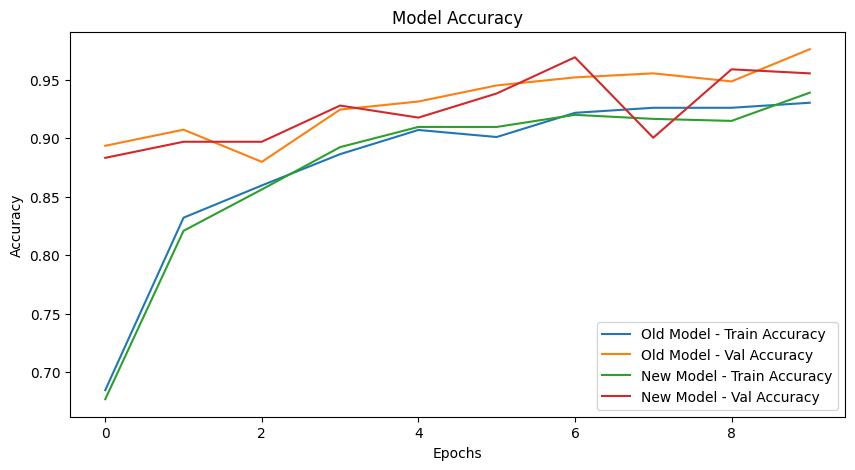

In [47]:
plt.figure(figsize=(10, 5))

plt.plot(history.history['accuracy'], label='Old Model - Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Old Model - Val Accuracy')
plt.plot(history1.history['accuracy'], label='New Model - Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='New Model - Val Accuracy')

plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1/1 [==============================] - 0s 56ms/step


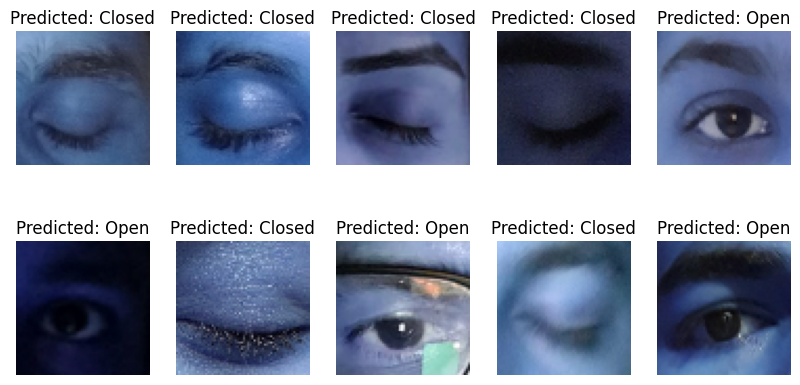

In [49]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i])
    plt.title('Predicted: ' + ('Open' if model.predict(X_test[i].reshape(1, 64, 64, 3)) > 0.5 else 'Closed'))
    plt.axis('off')
plt.show()